In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df=pd.read_csv("quantity_sum.csv")

In [3]:
df.head()

,active_date,quantity
0,1/2/2019,78.0
1,1/3/2019,78.0
2,1/4/2019,78.0
3,1/5/2019,7.0
4,1/6/2019,170.0


In [4]:
df.index=pd.to_datetime(df['active_date'])#df['active_date']

In [5]:
df=df[df.columns[1:2]]

In [6]:
df.head()

,quantity
active_date,
2019-01-02,78.0
2019-01-03,78.0
2019-01-04,78.0
2019-01-05,7.0
2019-01-06,170.0


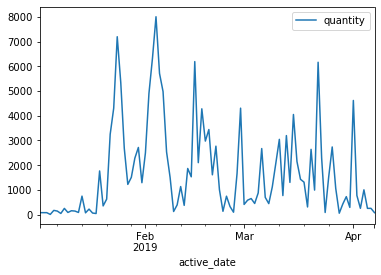

In [7]:
df.plot()

## Phân tích về material

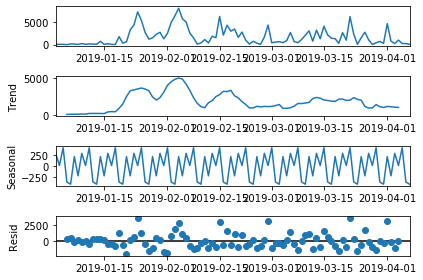

In [83]:
# Mô hình cộng tính
sd_add=seasonal_decompose(df,model='additive')
sd_add.plot()
plt.show()

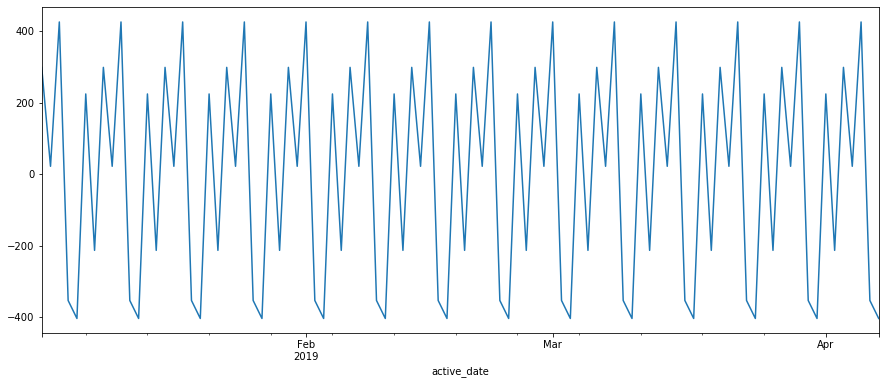

In [99]:
sd_add.seasonal.plot(figsize=(15,6))
plt.show()

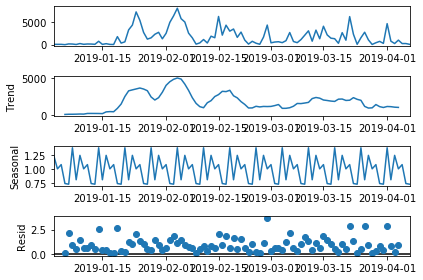

In [97]:
# Mô hình nhân
sd_mul=seasonal_decompose(df,model='multiplicative')
sd_mul.plot()
plt.show()

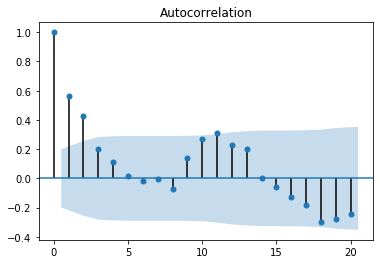

In [100]:
# Phân tích về tương quan
tsaplots.plot_acf(df.quantity)
plt.show()

# Kiểm tra tính dừng 

In [105]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    #rolmean = timeseries.rolling(12).mean()
    #rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    #plt.plot(rolmean, color='red', label='Rolling Mean')
    #plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    #perform dickey fuller test  
    print("Results of dickey fuller test")
    adft = adfuller(timeseries[timeseries.columns[0]],autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

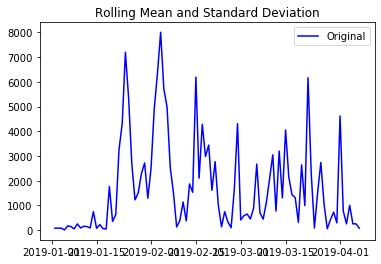

Results of dickey fuller test
Test Statistics                -1.791073
p-value                         0.384903
No. of lags used                9.000000
Number of observations used    86.000000
critical value (1%)            -3.508783
critical value (5%)            -2.895784
critical value (10%)           -2.585038
dtype: float64


In [106]:
test_stationarity(df)

## Biến đổi dẫn đến quá trình dừng

In [107]:
# first difference
data_log_diff=np.log(df).diff().dropna()

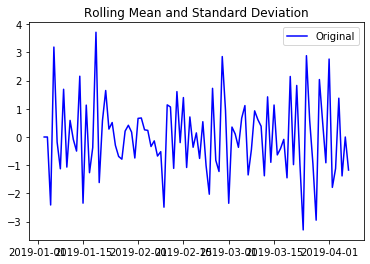

Results of dickey fuller test
Test Statistics                -4.842222
p-value                         0.000045
No. of lags used                7.000000
Number of observations used    87.000000
critical value (1%)            -3.507853
critical value (5%)            -2.895382
critical value (10%)           -2.584824
dtype: float64


In [108]:
test_stationarity(data_log_diff)

In [109]:
# inverting transformation
# first difference
#data_log_diff=np.log(data).diff().dropna()

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_1d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

# EXPONENTIAL SMOOTHING MODEL

In [ ]:
'''
statsmodels.tsa.holtwinters.ExponentialSmoothing(endog, trend=None, damped=False, seasonal=None, seasonal_periods=None, dates=None, freq=None, missing='none'
trend{“add”, “mul”, “additive”, “multiplicative”, None}, optional
damped bool, optional
seasonal {“add”, “mul”, “additive”, “multiplicative”, None}, optional
seasonal_periodsint, optional
'''
                                                 

In [9]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing as ES

In [26]:
n=np.int(0.8*len(df))
train=df.iloc[:n]
test=df.iloc[n:]

In [27]:
ntest=len(df)-n

C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


RMSE: 1659.1502546795296


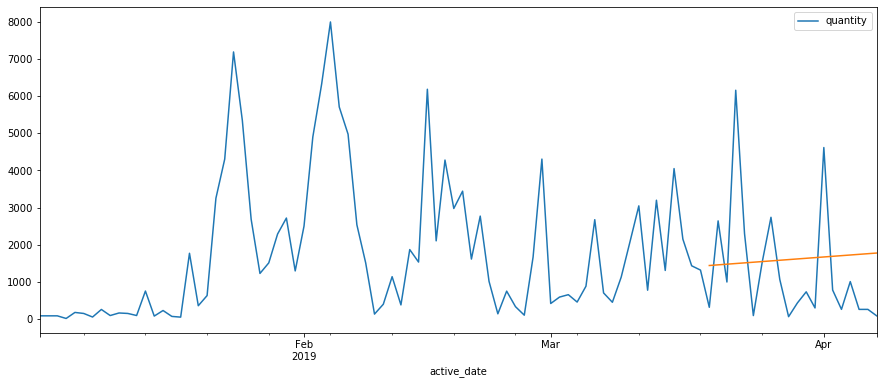

In [32]:
model=ES(train,trend='add').fit()
fc=model.forecast(ntest)
print('RMSE:', np.sqrt(mean_squared_error(test,fc)))
df.plot(figsize=(15,6))
fc.plot()
plt.show()

C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


RMSE: 1814.3028506933854


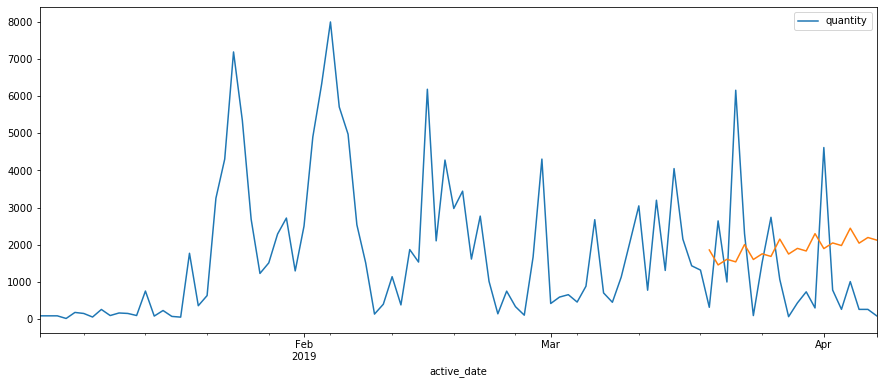

In [33]:
model=ES(train,trend='add',seasonal='add',seasonal_periods=4).fit()
fc=model.forecast(ntest)
print('RMSE:', np.sqrt(mean_squared_error(test,fc)))
df.plot(figsize=(15,6))
fc.plot()
plt.show()

C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


RMSE: 1833.1775585710425


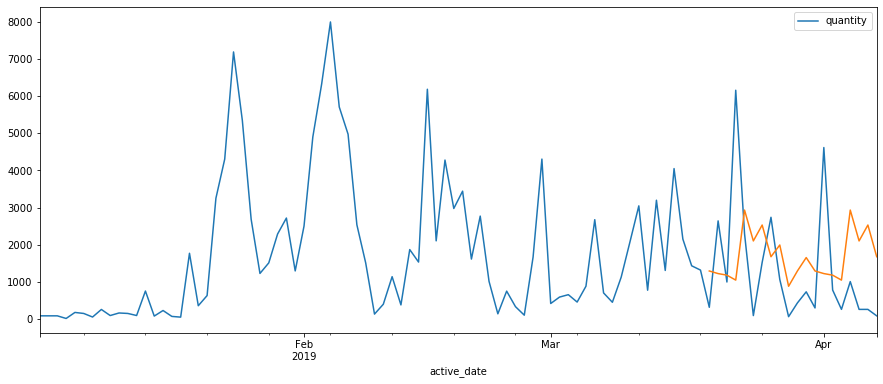

In [43]:
model=ES(train,trend='add',damped=True,seasonal='add',seasonal_periods=12).fit()
fc=model.forecast(ntest)
print('RMSE:', np.sqrt(mean_squared_error(test,fc)))
df.plot(figsize=(15,6))
fc.plot()
plt.show()

C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


RMSE: 1833.1775585710425


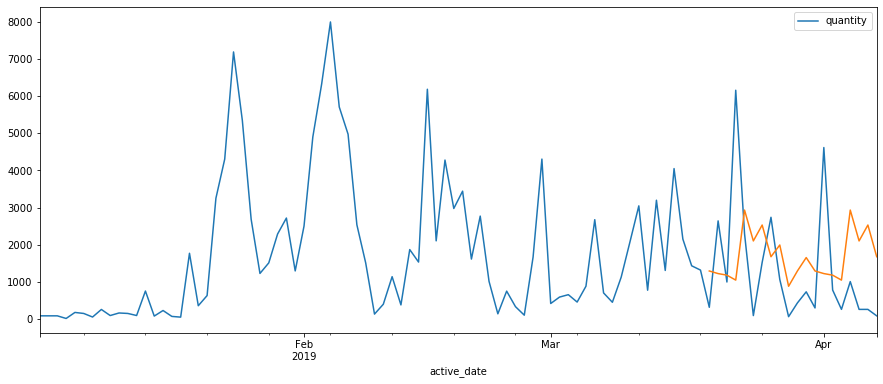

In [46]:
model=ES(train,trend='add',damped=True,seasonal='additive',seasonal_periods=12).fit()
fc=model.forecast(ntest)
print('RMSE:', np.sqrt(mean_squared_error(test,fc)))
df.plot(figsize=(15,6))
fc.plot()
plt.show()

In [41]:
list_optional=['add', 'mul','additive','multiplicative',None]
for t in list_optional:
    for s in list_optional:
        model=ES(train,trend=t,seasonal=s,seasonal_periods=12).fit()
        fc=model.forecast(ntest)
        print(t,", ",s,", ",'RMSE:', np.sqrt(mean_squared_error(test,fc)))

C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


add ,  add ,  RMSE: 2814.0501850499572


C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


add ,  mul ,  RMSE: 2345.6746613409005


C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


add ,  additive ,  RMSE: 2814.0501850499572


C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


add ,  multiplicative ,  RMSE: 2345.6746613409005
add ,  None ,  RMSE: 1659.1502546795296


C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


mul ,  add ,  RMSE: 1729.4841517442708


C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


mul ,  mul ,  RMSE: 5608.845278039299
mul ,  additive ,  RMSE: 1729.4841517442708


C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


mul ,  multiplicative ,  RMSE: 5608.845278039299
mul ,  None ,  RMSE: 1750.1031411139365


C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


additive ,  add ,  RMSE: 2814.0501850499572


C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


additive ,  mul ,  RMSE: 2345.6746613409005


C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


additive ,  additive ,  RMSE: 2814.0501850499572


C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


additive ,  multiplicative ,  RMSE: 2345.6746613409005
additive ,  None ,  RMSE: 1659.1502546795296


C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


multiplicative ,  add ,  RMSE: 1729.4841517442708


C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


multiplicative ,  mul ,  RMSE: 5608.845278039299
multiplicative ,  additive ,  RMSE: 1729.4841517442708


C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


multiplicative ,  multiplicative ,  RMSE: 5608.845278039299
multiplicative ,  None ,  RMSE: 1750.1031411139365
None ,  add ,  RMSE: 2235.8489041047387
None ,  mul ,  RMSE: 2679.249127178186
None ,  additive ,  RMSE: 2235.8489041047387
None ,  multiplicative ,  RMSE: 2679.249127178186


C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


None ,  None ,  RMSE: 1599.0136475575189


In [16]:
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools
from dmba import regressionSummary
import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from numpy import log
from statsmodels.tsa import tsatools, stattools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from dateutil.parser import parse
import pmdarima as pm
%matplotlib inline

no display found. Using non-interactive Agg backend


# Dự báo nguyên liệu (Khối lượng) sử dụng AUTOARIMA

In [125]:
# logarithm transformation
train=np.log(df)

In [126]:
model = pm.auto_arima(train, start_p=0, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=1,#None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=332.357, BIC=337.465, Time=0.018 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=317.237, BIC=324.899, Time=0.030 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=330.357, BIC=332.911, Time=0.017 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=306.634, BIC=316.849, Time=0.060 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=308.631, BIC=321.400, Time=0.036 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=304.667, BIC=317.436, Time=0.196 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=307.635, BIC=317.850, Time=0.083 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=308.490, BIC=323.814, Time=0.249 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=303.321, BIC=318.644, Time=0.281 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=302.917, BIC=315.

## Dự báo khối lượng cho nsteps ngày tiếp theo

In [127]:
nsteps=7
index_of_fc=pd.date_range(start=train.index[-1], periods=nsteps)

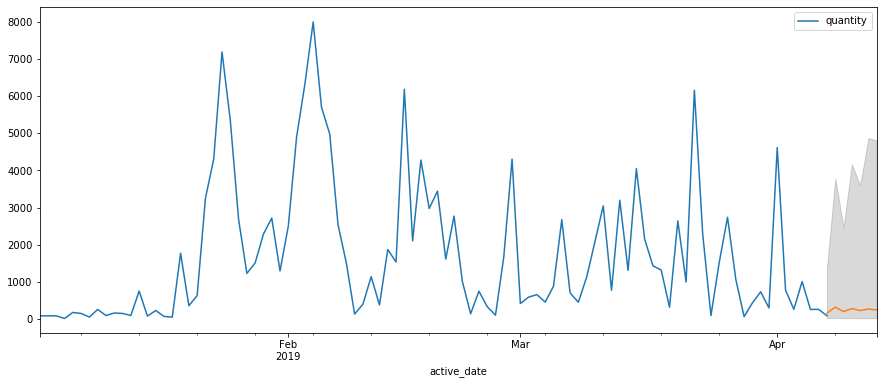

In [128]:
n_periods=nsteps
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
#fc,se, confint = model.forecast(ntes, return_conf_int=True,alpha=0.05)
index_of_fc=index_of_fc

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

ax=np.exp(train).plot(figsize=(15,6))
np.exp(fc_series).plot(ax=ax)
ax.fill_between(lower_series.index, np.exp(lower_series), np.exp(upper_series), color='k', alpha=.15)
plt.show()

# NON LINEAR MODEL

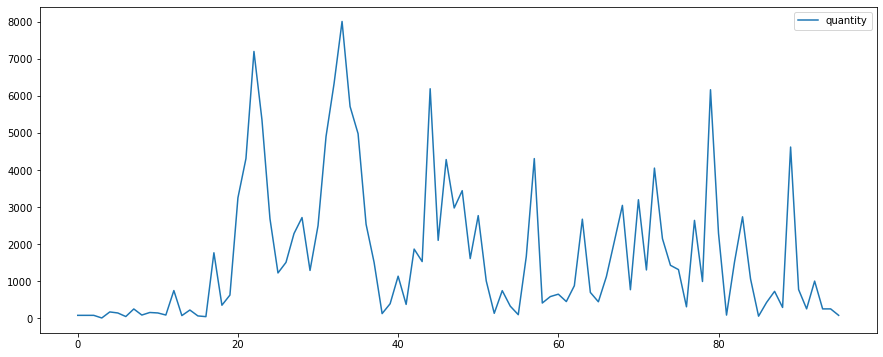

In [139]:
df=pd.read_csv("quantity_sum.csv")
df.plot(figsize=(15,6))
plt.show()

In [133]:
from fireTS.models import NARX, DirectAutoRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [140]:
x=df.index
exog=df['active_date']
y=df['quantity']

In [138]:
# Build a non-linear autoregression model with exogenous inputs
# using Random Forest regression as the base model
mdl1 = NARX(RandomForestRegressor(n_estimators=10),auto_order=2)

mdl1.fit(x, y)
ypred1 = mdl1.predict(x, y, step=3)

TypeError: __init__() missing 1 required positional argument: 'exog_order'

In [141]:
x = np.random.randn(100, 1)
y = np.random.randn(100)
mdl = NARX(RandomForestRegressor(), auto_order=2, exog_order=[2], exog_delay=[1])
mdl.fit(x, y)
ypred = mdl.predict(x, y, step=3)

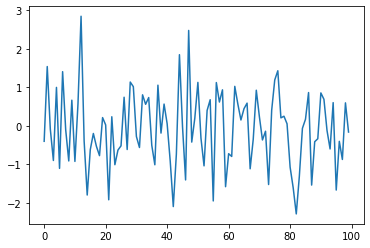

In [143]:
ax=plt.plot(y)
